#### Location: Greece
#### Time frame: 2014 - 2017

The purporse of the present data exploration notebook is to find the true big-scale wildfire cases using the FireHub hotspot service which is based mostly on the SEVIRI geostationary satellite. 

In the next project I will use these wildfire cases to validate different wildfire prediction models that comprise a Dynamic Data Driven Assimilation System (DDDAS) for wildfires, which calibrates a wildfire prediction model based on real-time wildfire hotspot data in order to make more accurate predictions of the wildfire course in the immediate future. In general a static wildfire model makes prediction based on static input parameters (weather, topography) which do not change during the simulation. This phenomenon leads to significant model drift as the prediction window increases. In contrary a Dynamic Data Driven Assimilation System for wildfires incorporates any updated information about the state of the wildfire in order to calibrate the wildfire model and make more accurate predictions.

Bellow we begin exploring the 4-year wildfire hotspot data of the FireHub service.

In [104]:
import urllib2
import numpy as np
from scipy.optimize import curve_fit
import json
import pandas as pd
from pprint import pprint
from operator import itemgetter
from tabulate import tabulate
import datetime
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import gmplot
from area import area
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib nbagg
import seaborn as sns

I exclude the municipalities around agricultural areas that generate false alarms

In [105]:
exclude = [u'Δ. Φαρσάλων', u'Δ. Ευρώτα', u'Δ. Ρήγα Φεραίου', u'Δ. Λαρισαίων', u'Δ. Κιλελέρ', u'Δ. Παλαμά', u'Δ. Μουζακίου', u'Δ. Χαλκιδέων']

Next I introduce a duration threshold for burning fires as I expect true wildfires to last for at least fireDurationThreshold=3 hours

I set the time frame to 2014 - 2017 as there is no available hotspot data for years <2014 

Finally, I store the JSON response of the call to the FireHub service

In [160]:
fireDurationThreshold = 3 #hours
dateStart = '2014-06-01T00:00:00'
dateEnd = '2017-08-31T23:59:00'

data = urllib2.urlopen("http://195.251.203.238/seviri/php/fhubdb.php?start="+dateStart+"&stop="+dateEnd+"&offset=&reftime=now")
data = json.load(data)

The service returns events from the following sources

1. Spinning Enhanced Visible and Infrared Imager (SEVIRI) of the geostationary MSG satellite
2. Visible Infrared Imaging Radiometer Suite (VIIRS) sensor of the Suomi National Polar-orbiting Partnership (NPP) satellite
3. Moderate Resolution Imaging Spectroradiometer (MODIS) of the Terra and Aqua polar orbiting satellites

The big hotspot tiles depicted bellow are the SEVIRI tiles while the smaller ones are from VIIRS or MODIS sensors. As expected from a sensor in geostationary orbit the SEVIRI tiles exhibit low spatial resolution when compared to the other two polar-orbiting sensors (~3500m. vs ~750m.) but the situation reverses completely in terms of temporal resolution (5min. vs. )

![title](seviri eos npp hotspots.jpg)

Bellow I remove the unwanted response data as some of them invalidate the JSON format (or this is what python's json.load() thinks so)

In [161]:
del data['timestamps']
del data['msg']
del data['status']
del data['args']

I parse the response looking for fire events that 

1. surpass the fireDurationThreshold
2. are not located in an agricultural municipality

Also I add an extra column that flags the fire events for which there exists an associated "eosevent" which means that, apart from SEVIRI, active fire was also observed by the higher resolution polar orbiting sensors. This is further indication that a true wildfire took place around that area that year and this maybe will guide me to a more efficient exploration process.

Finally I print the number of the remaining wildfire events

In [162]:
eosevents = data['eosevents']

events = []
count = 0
for event in data['events']:
    if event[6]>fireDurationThreshold and (event[3] not in exclude):
        eos=0
        for eosevent in eosevents:
            if eosevent[3] == event[3] and eosevent[4][:4] == event[4][:4]:
                eos=1

        events.append([event[3], event[6], event[4], event[7], event[8], eos, count])
        count+=1

print len(events)

201


Next I sort the remaining 201 fire events by date and print them

In [163]:
events.sort(key=itemgetter(2))
print tabulate(events, headers=['Municipality', 'Duration(h)', 'Date', 'Lon', 'Lat', 'VIIRS OR MODIS', 'ID'])

Municipality                            Duration(h)  Date                     Lon      Lat    VIIRS OR MODIS    ID
------------------------------------  -------------  -------------------  -------  -------  ----------------  ----
Δ. Ιάσμου                                      3.42  2014-06-15 09:45:00  25.239   41.0334                 0   191
Δ. Λοκρών                                     13.17  2014-06-26 11:45:00  23.1888  38.5892                 0    14
Δ. Λοκρών                                     12.58  2014-06-27 11:15:00  23.2214  38.598                  0    21
Δ. Σητείας                                    13.17  2014-07-03 14:25:00  26.1155  35.1023                 0    77
Δ. Βόλου                                      14.42  2014-07-04 09:30:00  22.6932  39.4407                 0    22
Δ. Φαιστού                                    11.83  2014-07-05 07:40:00  24.9122  34.9917                 0    34
Δ. Ανατολικής Μάνης                            9.42  2014-07-09 14:45:00  22.421

A couple of observations:

1. Some events that I would categorize as one single case are returned by the FireHub service as seperate events. While this may be expected in multiday events in case of reignitions etc. (eg. Δ. Λοκρών 2014-06-26), it is noteworthy that in other cases, eg. in the small island of Δ. Θάσου 2016-09-10 there are two events separated by 45 minutes. The following images suggest that 2 separate events are registered when 2 salient hotspots are observed (colors represent the hotspot's confidence).
   !["asas"](thasos1.jpg) ![title](thasos2.jpg)

2. The whole year of 2014 does not contain VIIRS and MODIS reports. For some reason the FireHub service does not include them.

3. There exist only some wildfire events that are't reported either by VIIRS nor MODIS sensors. A quick Google search suggests that at least some of them are true wildfire cases, but I'm not going to bother yet as I'll do further cleaning and reassess this flag with the remaining "final" events.

To proceed with selecting true wildfire cases I need to explore the expansion trend of each event; i.e. ideally I want to simulate events which are quite big to compensate for SEVIRI's low spatial resolution, and also events that are not very erratic, having a near constant stream of hotspots without big no-reported-data spaces in between and possibly exhibiting clear expansion trends (without too many or too significant ups and downs in burning area). For this reason I will compute the sequence of the reported burning area of each event over time.

WARNING: The following cell may execute for a couple of hours as subsequent calls are made to the FireHub service and a dataframe of about 2 million rows of hotspot data is constructed.

In [165]:
events.sort(key=itemgetter(1))
fextent=0.3
timestep=5 #minutes
countEvent = 0
emptyJSON = 0

polygons = []
for event in events:
    endingdatetime=datetime.datetime.strptime(event[2], '%Y-%m-%d %H:%M:%S') + datetime.timedelta(minutes=event[1]*60)
    dateStart=datetime.datetime.strptime(event[2], '%Y-%m-%d %H:%M:%S') - datetime.timedelta(minutes=1)
    lats = []
    lngs = []
    areas = []
    minFromIgnition = 0
    forestArea = Polygon([(event[3]-fextent, event[4]+fextent), (event[3]+fextent, event[4]+fextent), 
                          (event[3]+fextent, event[4]-fextent), (event[3]-fextent, event[4]-fextent)])

#     gmap = gmplot.GoogleMapPlotter(event[4], event[3], 11)
#     gmap.plot(
#         [event[4]+fextent, event[4]+fextent, event[4]-fextent, event[4]-fextent, event[4]+fextent], 
#         [event[3]-fextent, event[3]+fextent, event[3]+fextent, event[3]-fextent, event[3]-fextent],'green',edge_width=4)
    
    while True:
        dateEnd=dateStart + datetime.timedelta(minutes=timestep)
        data2 = urllib2.urlopen("http://ocean.space.noa.gr/seviri/postgres_interface/fend.php?tm_from="+dateStart.strftime("%Y-%m-%dT%H:%M:%S")+"&tm_to="+dateEnd.strftime("%Y-%m-%dT%H:%M:%S")+"&format=geojson")
  
        try:
            data2 = json.load(data2)
            for i in range (len(data2['features'])):
                        point = Point(data2['features'][i]['centroid']['coordinates'][0], 
                                      data2['features'][i]['centroid']['coordinates'][1])
                        if forestArea.contains(point):
                            lats.append(data2['features'][i]['centroid']['coordinates'][1])
                            lngs.append(data2['features'][i]['centroid']['coordinates'][0])
                            areaconf=0
                            for j in range (len(data2['features'][i]['geometry']['coordinates'])):
                                polygons.append([data2['features'][i]['geometry']['coordinates'][j], 
                                                 data2['features'][i]['properties']['HAT'],
                                                 minFromIgnition,
                                                 event[6],
                                                 data2['features'][i]['properties']['CONF'],
                                                 area({'type':'Polygon',
                                                             'coordinates':data2['features'][i]['geometry']['coordinates'][j]
                                                            })*0.000001])        
        except ValueError:  
            emptyJSON+=1

#         gmap.scatter(lats, lngs, '#3B0B39', size=250, marker=False)
#         gmap.draw("mymap.html")
        dateStart=dateStart + datetime.timedelta(minutes=timestep)
        minFromIgnition+=timestep
        if (dateStart>endingdatetime):
            break

    countEvent+=1
    print 'Consumed Event #'+str(event[6])+' ('+str(countEvent)+'/'+str(len(events))+')'

print 'Total number of hotspots '+str((len(polygons)))

Consumed Event #118 (1/201)
Consumed Event #92 (2/201)
Consumed Event #165 (3/201)
Consumed Event #164 (4/201)
Consumed Event #33 (5/201)
Consumed Event #183 (6/201)
Consumed Event #128 (7/201)
Consumed Event #184 (8/201)
Consumed Event #167 (9/201)
Consumed Event #97 (10/201)
Consumed Event #195 (11/201)
Consumed Event #44 (12/201)
Consumed Event #148 (13/201)
Consumed Event #112 (14/201)
Consumed Event #153 (15/201)
Consumed Event #198 (16/201)
Consumed Event #189 (17/201)
Consumed Event #177 (18/201)
Consumed Event #180 (19/201)
Consumed Event #147 (20/201)
Consumed Event #113 (21/201)
Consumed Event #149 (22/201)
Consumed Event #142 (23/201)
Consumed Event #127 (24/201)
Consumed Event #80 (25/201)
Consumed Event #39 (26/201)
Consumed Event #146 (27/201)
Consumed Event #163 (28/201)
Consumed Event #32 (29/201)
Consumed Event #116 (30/201)
Consumed Event #111 (31/201)
Consumed Event #139 (32/201)
Consumed Event #194 (33/201)
Consumed Event #143 (34/201)
Consumed Event #185 (35/201)
C

I put everything into a dataframe to analyze the hotspot information easily

In [166]:
polygonsDF = pd.DataFrame(polygons,columns=['Coordinates','Datetime', 'MinutesFromIgnition', 'EventId', 'Confidence', 'Area']) 
polygonsDF

,Coordinates,Datetime,MinutesFromIgnition,EventId,Confidence,Area
0,"[[[24.02685, 37.81652], [24.02667, 37.81652], ...",2014-08-04 10:20:00,15,118,1.607713,0.000097
1,"[[[24.02208, 37.82131], [24.0225, 37.82124], [...",2014-08-04 10:20:00,15,118,1.607713,0.232893
2,"[[[24.02685, 37.82141], [24.02685, 37.82121], ...",2014-08-04 10:20:00,15,118,1.607713,0.000355
3,"[[[24.033, 37.78791], [24.0329, 37.78791], [24...",2014-08-04 10:20:00,15,118,2.250877,0.289661
4,"[[[24.03917, 37.79205], [24.033, 37.79205], [2...",2014-08-04 10:20:00,15,118,2.221797,0.295511
5,"[[[23.99698, 37.80674], [23.99601, 37.80674], ...",2014-08-04 10:20:00,15,118,1.010126,0.004284
6,"[[[24.00863, 37.81309], [24.00856, 37.81294], ...",2014-08-04 10:20:00,15,118,1.008417,0.001868
7,"[[[24.00855, 37.81406], [24.00834, 37.81385], ...",2014-08-04 10:20:00,15,118,1.008417,0.000866
8,"[[[24.00217, 37.7893], [24.00202, 37.78935], [...",2014-08-04 10:20:00,15,118,2.201011,0.289864
9,"[[[24.03301, 37.80025], [24.03281, 37.80022], ...",2014-08-04 10:20:00,15,118,1.704973,0.205353


Lets plot the distribution of the hotspots' Confidence and Area values.

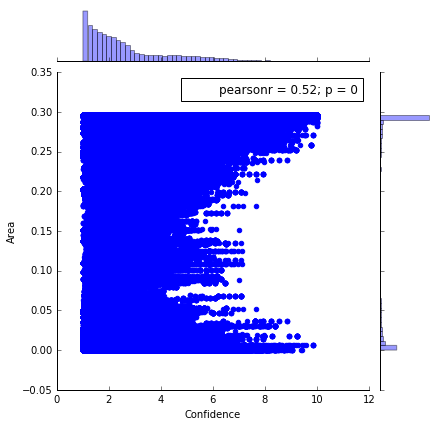

In [167]:
sns.jointplot(x="Confidence", y="Area", data=polygonsDF)

We observe that the vast majority of the hotspot polygons 
1. have confidence bellow 50% and 
2. most of them cover areas of just bellow 0.3km^2 with a second smaller group covering areas way bellow 0.05km^2. 

I address the issues 1. and 2. bellow:
    1. The low confidence values of the majority of the hotspots are due to the Firehub service trying to refine SEVIRI's original spatial resolution with a process of downscaling the 3.5km hotspots into smaller areas (3.5km -> 500m) and then reducing the confidence of the 500m hotspots that exhibit low probability of burning based on a statistical analysis of historical data for burned areas and the hotspot's corresponding topographic characteristics (for more details check [Integrating Scale in Remote Sensing and GIS, Chapter 6]).
    2. One of the filters applied to the 500m hotspots crops the hotspot areas that are located over water (coastline, lakes, etc.) and other CORINE Land Cover codes (mostly rural areas and agricultural vegetation) resulting in many 500m hotspots being severely reduced in size.

Now I would like to know how the burning area is growing over time factoring in its confidence. So I construct an extra column called "BurningArea" which is the product of the columns "Confidence" (normalized in the [0,1] space) and "Area". In this way the extent of a hotspot area with a confidence value of 0.5 will count as half in comparison to the extent of the same hotspot area with confidence 1.

In [168]:
polygonsDF['BurningArea'] = np.multiply(polygonsDF['Confidence']*0.1, polygonsDF['Area'])
polygonsDF.describe()

,MinutesFromIgnition,EventId,Confidence,Area,BurningArea
count,1.887575e+06,1.887575e+06,1.887575e+06,1.887575e+06,1.887575e+06
mean,4.042726e+02,3.895172e+01,2.699754e+00,1.828300e-01,6.016513e-02
std,4.044270e+02,4.039513e+01,1.677369e+00,1.228508e-01,5.977473e-02
min,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.250000e+02,9.000000e+00,1.455505e+00,3.417298e-02,4.834672e-03
50%,2.650000e+02,2.500000e+01,2.124145e+00,2.532295e-01,4.971000e-02
75%,5.700000e+02,5.000000e+01,3.423655e+00,2.950720e-01,8.776628e-02
max,2.405000e+03,2.000000e+02,1.000000e+01,2.962266e-01,2.959830e-01


Now, for each event, I compute the sum of "BurningArea" over time (for each 5min hotspot update)

In [169]:
confAreaByTimestep = polygonsDF.groupby(['EventId', 'MinutesFromIgnition'], as_index=False)['BurningArea'].sum()
confAreaByTimestep

,EventId,MinutesFromIgnition,BurningArea
0,0,0,2.580932
1,0,10,3.128813
2,0,15,3.523416
3,0,20,3.788863
4,0,25,7.186172
5,0,30,6.899729
6,0,35,4.738042
7,0,40,17.620120
8,0,45,23.066006
9,0,50,22.301308


Next I plot the BurningArea over time for some wildfire events in order to observe how it looks like.

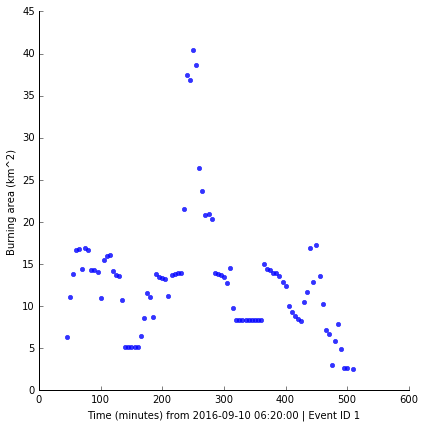

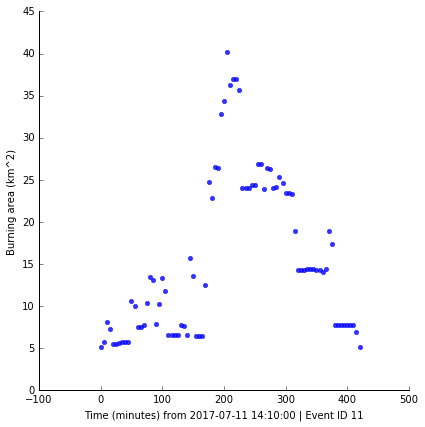

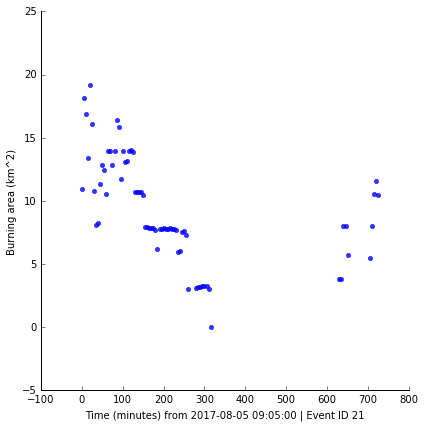

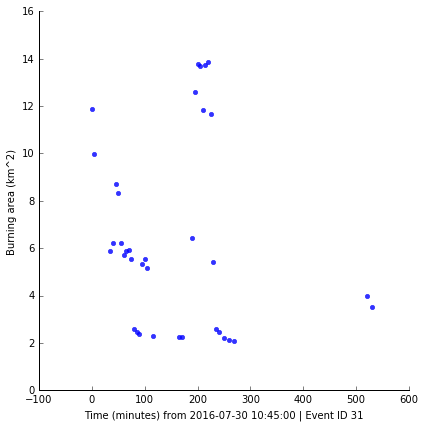

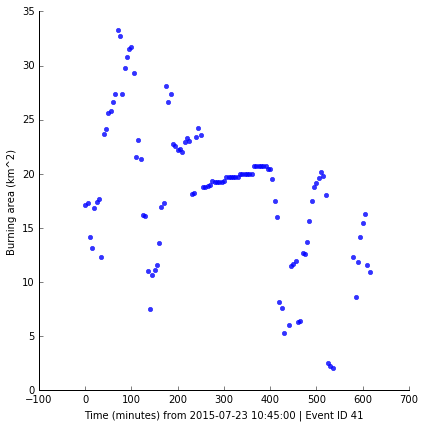

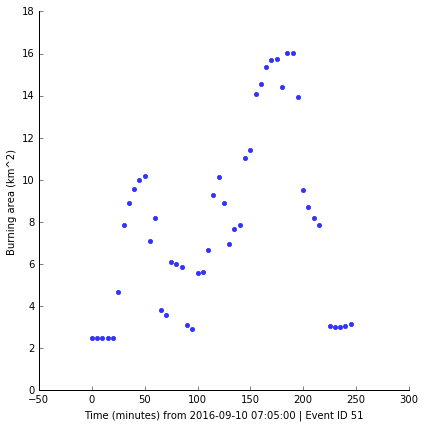

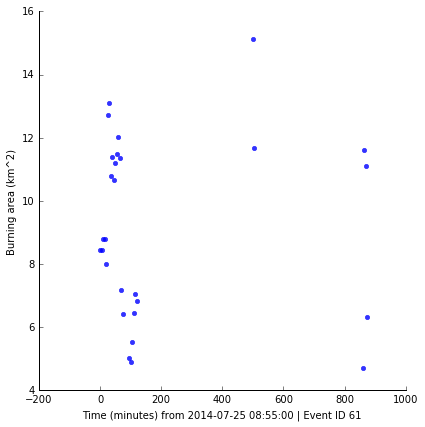

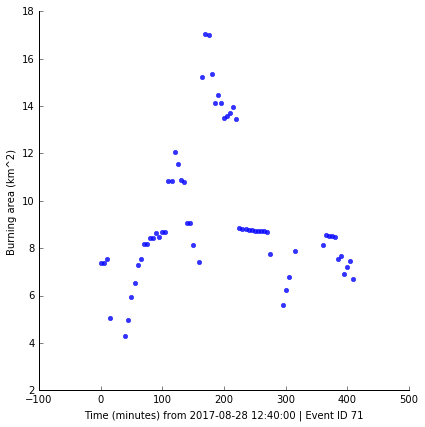

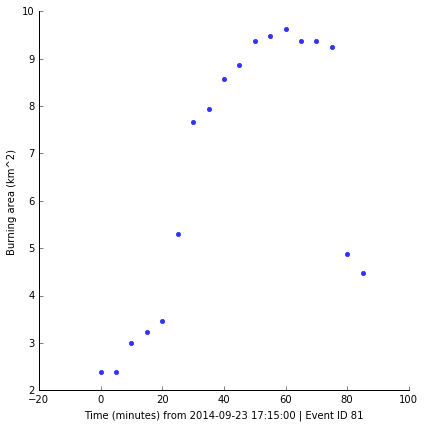

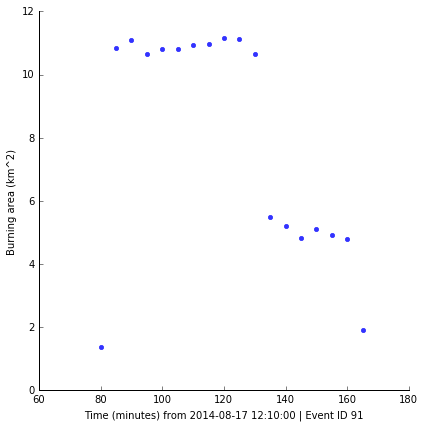

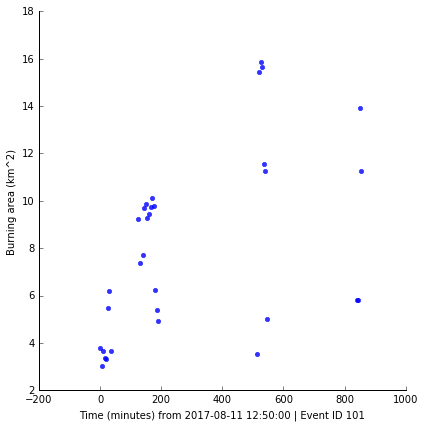

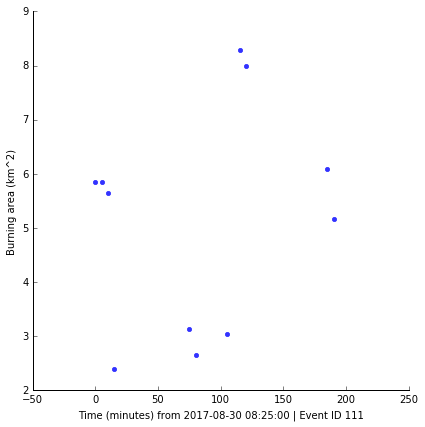

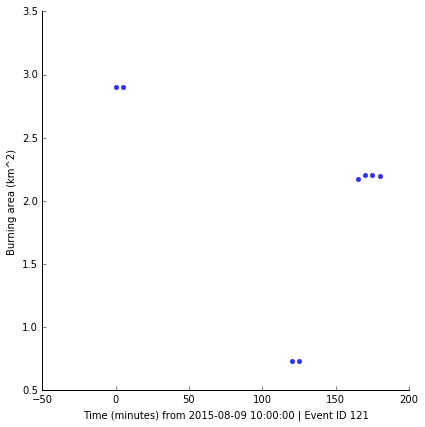

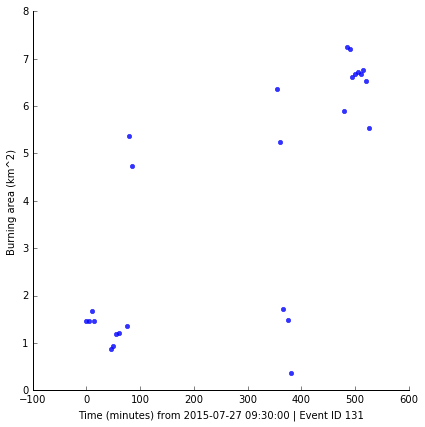

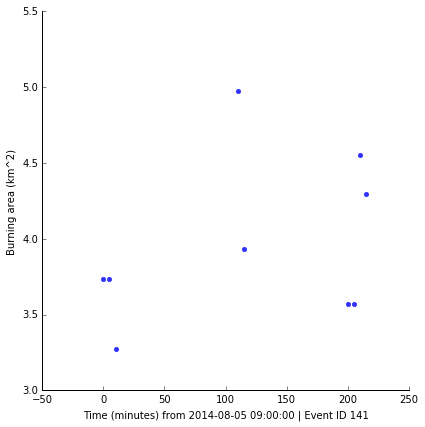

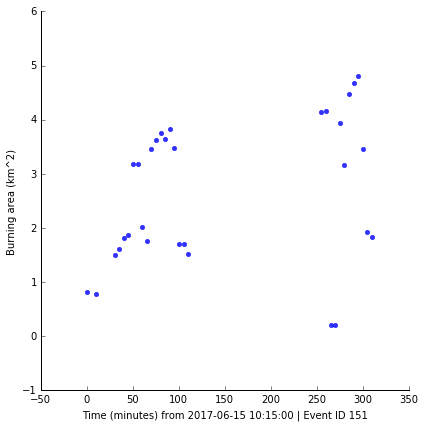

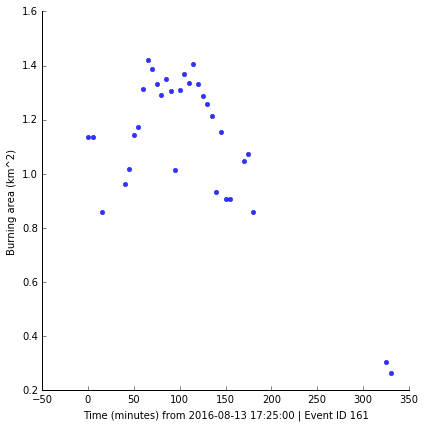

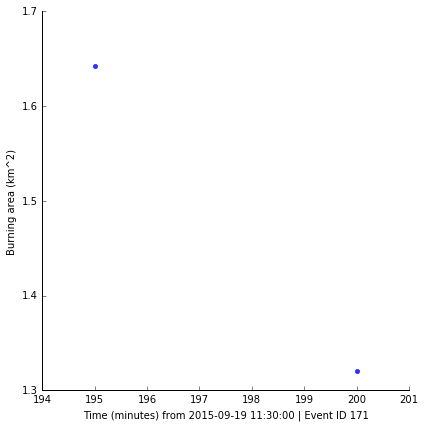

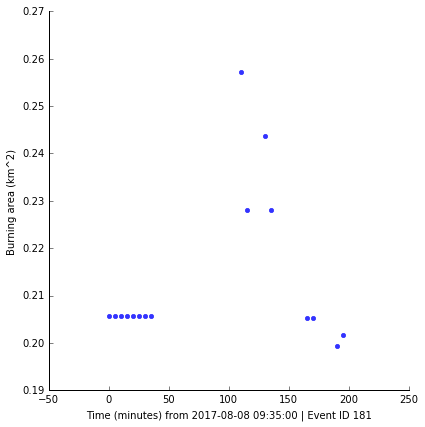

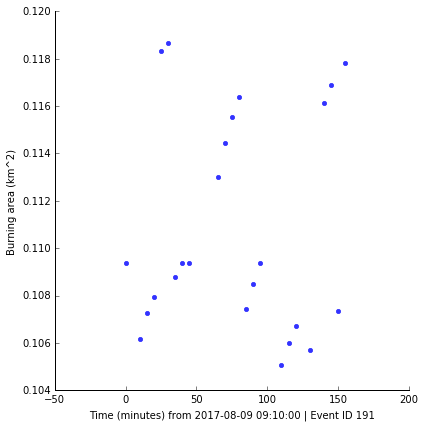

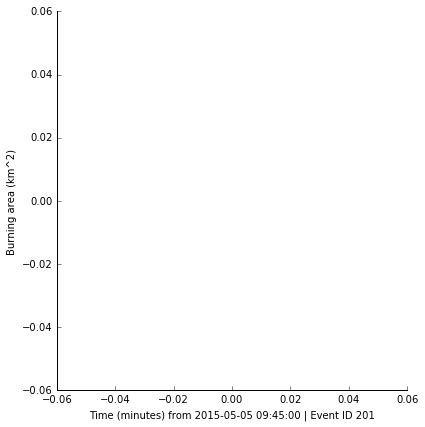

In [179]:
for i in range(0, countEvent, 10):
    ax = sns.lmplot('MinutesFromIgnition', 'BurningArea', size=6, 
               data=confAreaByTimestep.loc[confAreaByTimestep['EventId'] == i+1], fit_reg=False)
    ax.set(xlabel='Time (minutes) from '+events[i][2]+' | Event ID '+str(i+1), 
           ylabel='Burning area (km^2)')

Two things that stand out at first are: 
1. The reported burning area for some events is mostly bellow the SEVIRI's native spatial resolution (~12km^2), so in these cases we're not going to observe (let alone predict) any significant wildfire growth. I'm going to remove these events as there's no significant growth for a wildfire simulator to predict.
2. Some events are more erratic than others, exhibiting wide spans without hotspot data and multiple ups and downs in their reported burning area. There are two ways I can deal with this: a) Remove such events completely or b) Treat the spans of no data as no-decision spans, i.e. the simulation continues without dynamic data assimilation. I will choose option b) but I will remove the events that exhibit no hotspot data for >50% of their time.

Before continuing I will place a cap on the overall time of events at 900 minutes (15 hours), so I will remove hotspot data past this time threshold. This threshold is arbitrary but in general after some hours we can expect significant firefighting forces to be thrown into a wildfire for which we have no information whatsoever. This makes any attempt to predict the wildfire's propagation a futile process. A wildfire simulator provides its most value during the initial stages of a wildfire, where the proper allocation of the first respondents is critical for the wildfire evolution. 15 hours provide plenty of time.

After all these changes I plot the remaining events again but I also add a 2nd order polynomial fit in order to see if it can capture the 3 phases of a typical wildfire expansion (1. grow 2. maintain 3. retreat) (I expect higher order polynomials to overfit the data)

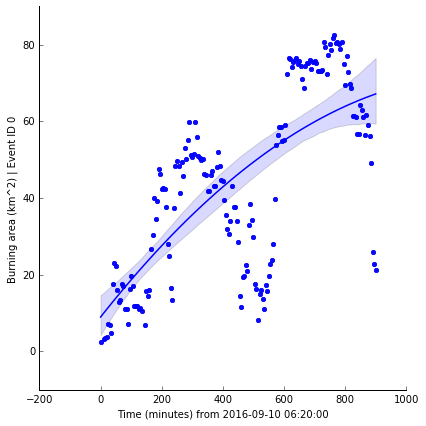

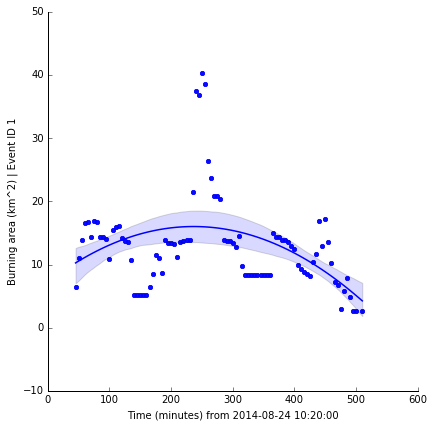

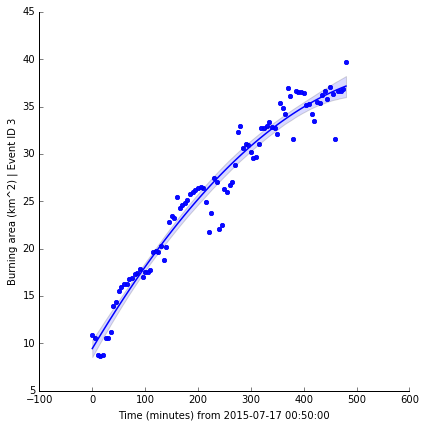

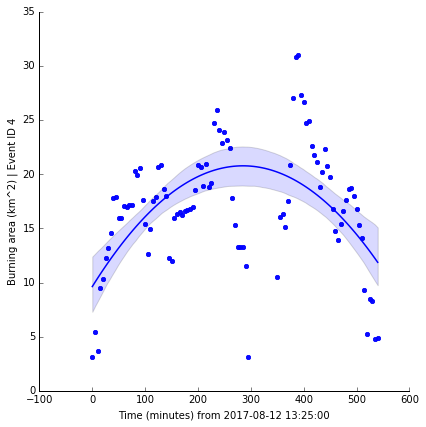

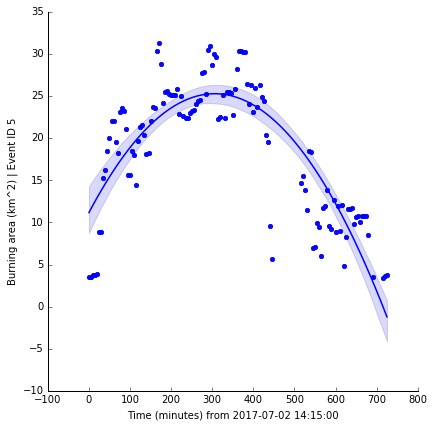

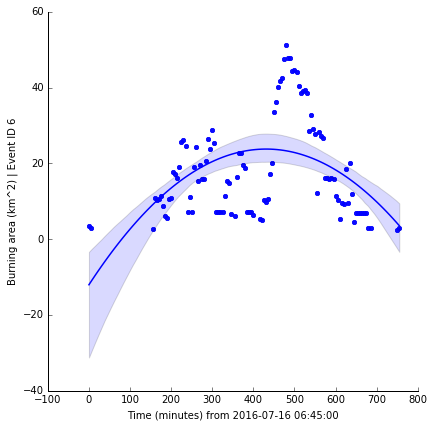

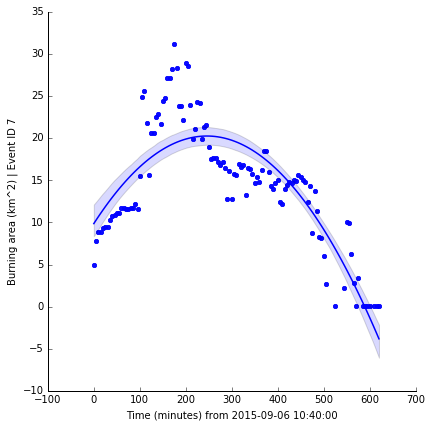

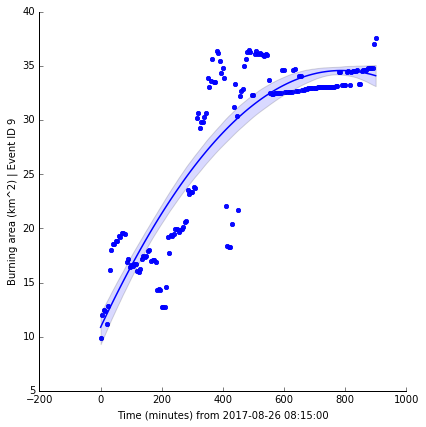

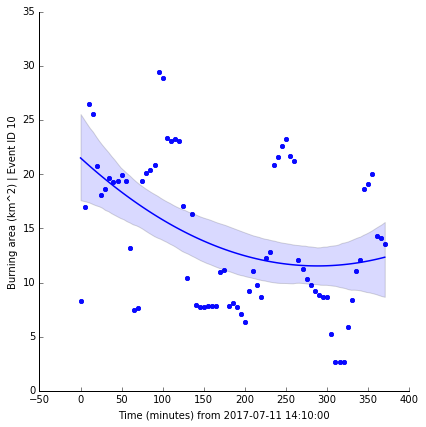

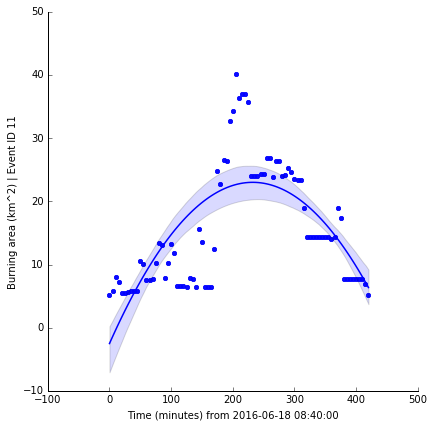

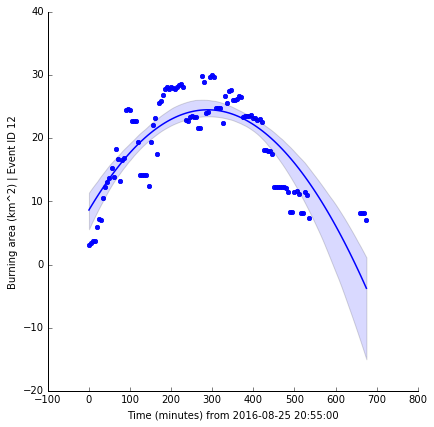

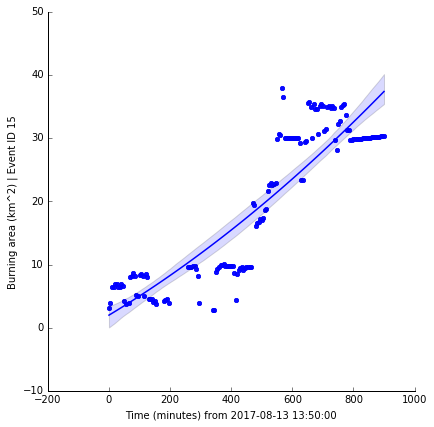

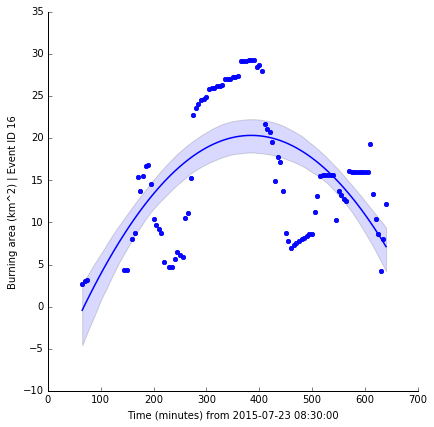

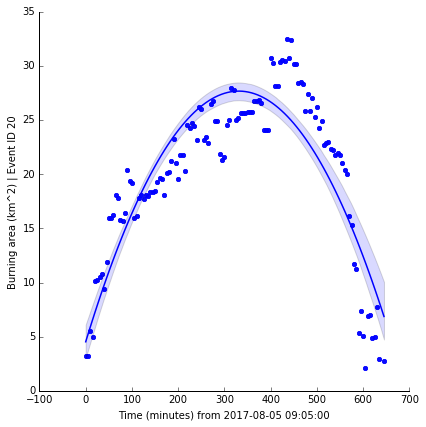

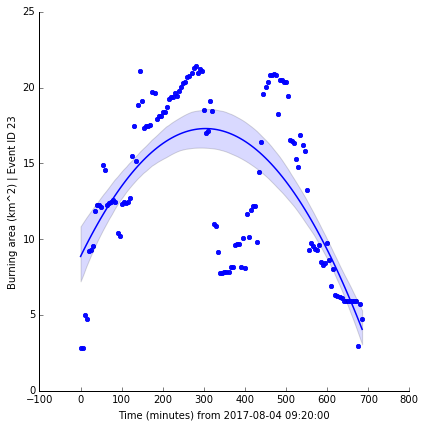

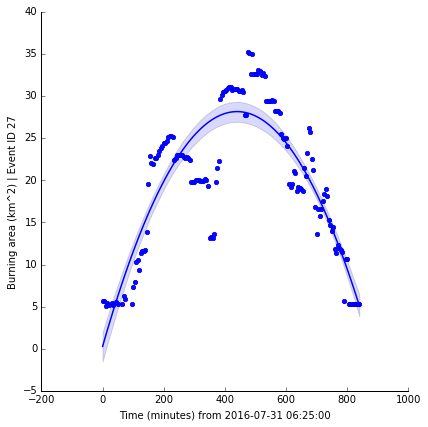

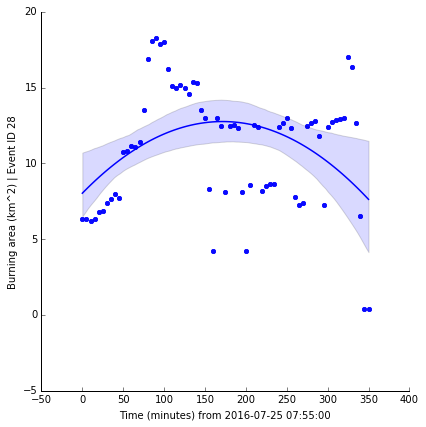

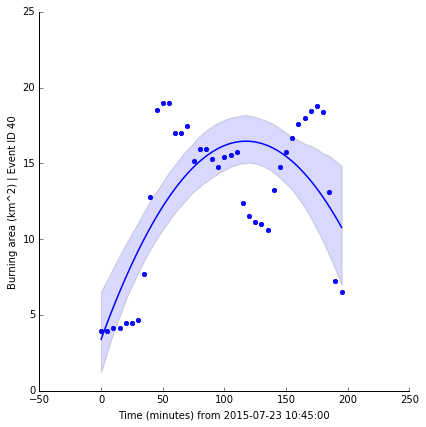

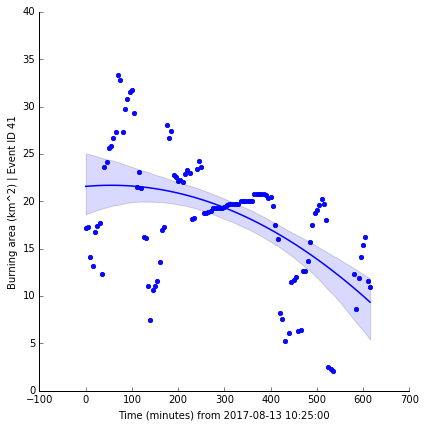

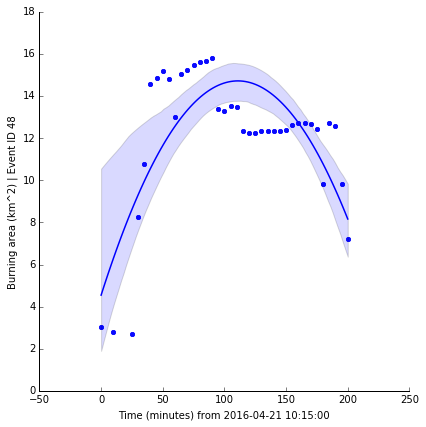

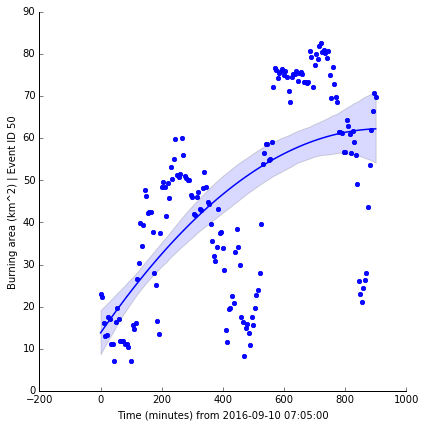

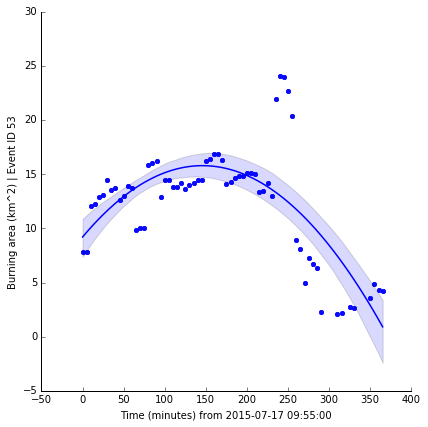

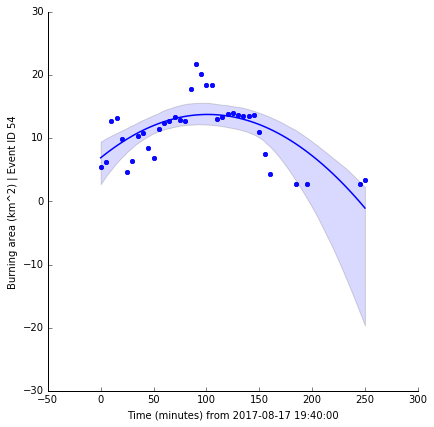

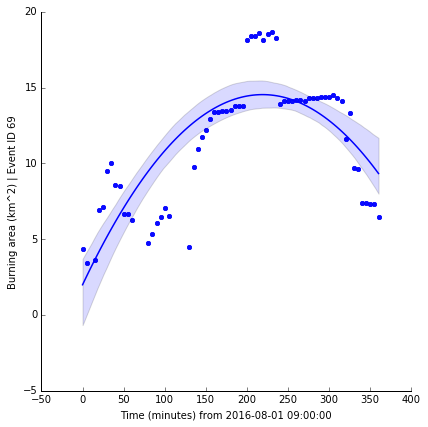

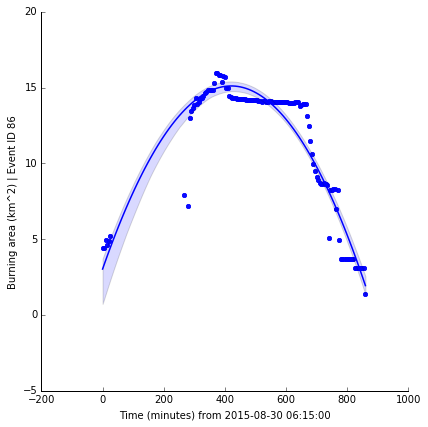

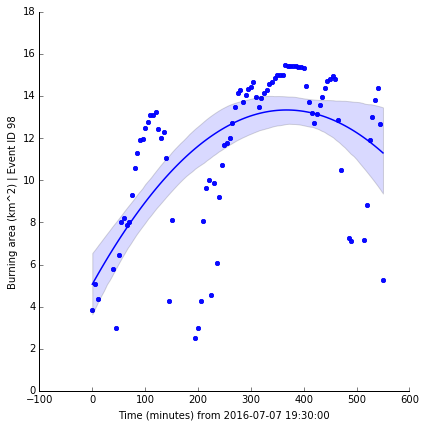

In [176]:
events.sort(key=itemgetter(6))

events900 = confAreaByTimestep[confAreaByTimestep.MinutesFromIgnition <= 900]

events12km = events900.groupby('EventId', as_index=False)['BurningArea'].median()

agg_funcs = {'MinutesFromIgnition':np.max, 'BurningArea':np.count_nonzero}
eventsMaxMinutes = events900.groupby('EventId', as_index=False).agg(agg_funcs)
eventsMaxMinutes.columns = ['EventId', 'Count', 'Maxminute']
eventsMaxMinutes['50prctON'] = eventsMaxMinutes['Maxminute']/2 < eventsMaxMinutes['Count']*5

eventsFinal = pd.DataFrame({'prctON50':eventsMaxMinutes['50prctON'], 
                            'km12':events12km['BurningArea']>=12,
                            'EventId':events12km['EventId']})

eventsFinal = eventsFinal[eventsFinal.prctON50==True]
eventsFinal = eventsFinal[eventsFinal.km12==True]

for index, row in eventsFinal.iterrows():
    sns.lmplot('MinutesFromIgnition', 'BurningArea', size=6, 
               data=events900.loc[events900['EventId'] == row["EventId"]], fit_reg=False)
    ax = sns.regplot(x="MinutesFromIgnition", y="BurningArea", 
                     data=events900.loc[events900['EventId'] == row["EventId"]],order=2, truncate=True)
    ax.set(xlabel='Time (minutes) from '+events[row["EventId"]][2], 
           ylabel='Burning area (km^2) | Event ID '+str(row["EventId"]))

Let's print the parameters of the polynomial regression model for each event before the discussion of the graphs.

In [177]:
for index, row in eventsFinal.iterrows():
    x = np.array(events900.loc[events900['EventId'] == row['EventId'], 'MinutesFromIgnition'])
    y = np.array(events900.loc[events900['EventId'] == row['EventId'], 'BurningArea'])

    def fit_func(x, a, b, c):
        return a*x**2 + b*x + c

    params = curve_fit(fit_func, x, y)

    [a, b, c] = params[0]
    print 'Event '+str(row['EventId'])+' a='+str(a)+' b='+str(b)+' c='+str(c)

Event 0 a=-4.03977503875e-05 b=0.101008186397 c=8.97901486801
Event 1 a=-0.000157295557829 b=0.0743783845916 c=7.22011663578
Event 3 a=-7.5181900893e-05 b=0.09381736423 c=9.46066906721
Event 4 a=-0.000137206002002 b=0.0782367117625 c=9.62937645809
Event 5 a=-0.000150888597456 b=0.0923146928391 c=11.1642165842
Event 6 a=-0.000192691739467 b=0.166138675016 c=-12.0124527356
Event 7 a=-0.00017207672452 b=0.0846108880875 c=9.85815244536
Event 9 a=-3.81864570613e-05 b=0.0601894799002 c=10.8688543635
Event 10 a=0.000120066247828 b=-0.0692135306788 c=21.5096551312
Event 11 a=-0.000472999165713 b=0.219771920693 c=-2.51590683852
Event 12 a=-0.000189833776361 b=0.109776190978 c=8.62835055454
Event 15 a=1.13417822116e-05 b=0.0291477985659 c=1.97918061868
Event 16 a=-0.000202977867634 b=0.156241879928 c=-9.73463312838
Event 20 a=-0.000211250204462 b=0.139880358383 c=4.52743322188
Event 23 a=-9.12646596705e-05 b=0.0554931010402 c=8.86712897082
Event 27 a=-0.000144029944603 b=0.126760637439 c=0.27108

Observations:
    1. Most events exhibit a concave graph with a downward parabola. This is what we expect from a typical wildfire: At first it grows, next it stabilizes and then finally it retreats. Of course this may not be the case for some events, especially large ones which in the long run may exhibit reignitions etc. However, I would argue that a downward parabola trend is the norm for the first hours of a wildfire which are the most critical, and consist the time window where wildfire simulations offer the most value.
    
    2. Some events exhibit quadratic graphs that clearly do not fit the data very well (eg. Event#10, Event#41). This is probably due to lower SNR in the hotspot data, as we do not generally observe forest areas to turn from burning to not burning and vice versa with so high frequency especially at the beggining of a wildfire. I expect these events to be a bad fit for a wildfire DDDAS test.
    
    3. The parameters of the polynomial regression model show that the Events #10 and #41 are indeed outliers, i.e. As per parameter a the Event #10 exhibits the only convex graph (I dot not count Event #15 as I cropped it to 15 hours and it's a close call anyway) and a downward growth trend (parameter b) at the beggining of the fire, which is also true for Event #41. Both of these events also have the highest c parameter, which is a sign that SEVIRI's fire detection was delayed for some reason.

Points 2. and 3. suggest that the Events #10 and #41 are indeed a bad fit for a wildfire DDDAS test so I'm going to remove them.

In [180]:
eventsFinal = eventsFinal[eventsFinal.EventId!=10]
eventsFinal = eventsFinal[eventsFinal.EventId!=41]
print "Remaining Events: "+str(len(eventsFinal.index))

eventsDF = pd.DataFrame(events)
eventsDF.columns = ['Municipality', 'Duration(h)', 'Date', 'Lon', 'Lat', 'VIIRS OR MODIS', 'ID']
eventsDF = eventsDF[eventsDF['ID'].isin(eventsFinal['EventId'])]
eventsDF.set_index('ID')
eventsDF.sort_values(by='Date')

Remaining Events: 24


,Municipality,Duration(h),Date,Lon,Lat,VIIRS OR MODIS,ID
1,Δ. Καλαμπάκας,9.67,2014-08-24 10:20:00,21.755424,39.768741,0,1
3,Δ. Μονεμβασιάς,8.00,2015-07-17 00:50:00,23.104634,36.533542,1,3
53,Δ. Βύρωνος,6.25,2015-07-17 09:55:00,23.779716,37.958207,1,53
16,Δ. Ρόδου,11.25,2015-07-23 08:30:00,27.947200,36.197684,1,16
40,Δ. Δίρφυων - Μεσαπίων,3.42,2015-07-23 10:45:00,23.755745,38.660222,1,40
86,Δ. Λέσβου,14.92,2015-08-30 06:15:00,26.565766,39.077407,1,86
7,Δ. Αμφίκλειας - Ελάτειας,10.42,2015-09-06 10:40:00,22.898799,38.529733,1,7
48,Δ. Ιεράπετρας,3.33,2016-04-21 10:15:00,25.642020,35.052540,0,48
11,Δ. Ρόδου,7.17,2016-06-18 08:40:00,27.793001,36.065731,1,11
98,Δ. Ψαρών,9.67,2016-07-07 19:30:00,25.566530,38.581502,1,98


In the next project we will gather the weather and topographic input data for these 24 events and perform wildfire simulations.

An interesting question to investigate later would be: Can we increase the accuracy of an offline simulation using the quadratic fit of the event (detecting outliers in the hotspot data, etc.) and if so, how soon can we estimate adequately the final quadratic fit using hotspot data in real-time (as they arrive) in order for it to be used in a real-time setting?